In [2]:
#install many of the necessary libraries. Will typically initially get an error regarding "pillow". Just re run cell
import solaris as sol
import numpy as np
import geopandas as gpd
import descartes
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os

In [3]:
#make the directories to store processed/output data
data_dir = '../../data/processed/'
!mkdir ../../data/processed/images-256
img_path = '../../data/processed/images-256'
!mkdir ../../data/processed/masks-256
mask_path = '../../data/processed/masks-256'


mkdir: ../../data/processed/images-256: File exists
mkdir: ../../data/processed/masks-256: File exists


In [4]:
#set the file paths for the first selected imagery and labels:
geojson = '../../data/raw/train_tier_1/acc/665946-labels/665946.geojson'
geotif = '../../data/raw/train_tier_1/acc/665946/665946.tif'

In [5]:
# load geojson for labels

label_df = gpd.read_file(geojson)
# remove empty rows
label_df = label_df[label_df['geometry'].isna() != True] 


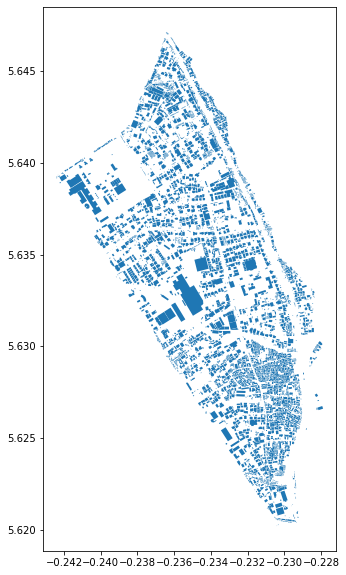

In [6]:
#visualize the polygons
label_df.plot(figsize=(10,10))